<a href="https://colab.research.google.com/github/danielkorat/dynamic_ds/blob/main/Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from tqdm import tqdm
from collections import defaultdict
from numpy import log

from nlp.data import get_ngram_counts, plot_token_frequencies
from nlp.model import train_simple_model
from count_min_param import CountMinEvaluation
from cutoff_count_min_param import LearnedCountMinEvaluation
from plotting.plot_loss_vs_space import PlotLossVsSpace



In [20]:
DS_ITEM_COUNTS_PATH= './nlp/2_grams_wikicorpus_1.0%.npz'
DS_NAME='wikicorpus'

In [ ]:
### get ngrams for wiki. we only used 10% of the data as dataset is huge. only run if necessary... ###

#get_ngram_counts('wikicorpus', limit_prop=0.1, n=2, tokens_key='sentence', name='tagged_en')

# actual tokens frequency

Num of unique tokens: 2070314


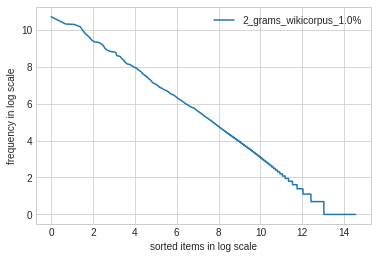

In [21]:
plot_token_frequencies(DS_ITEM_COUNTS_PATH)

# evaluating original count-min and count-sketch algorithms on data

In [ ]:
### count sketch ###

DATA = DS_ITEM_COUNTS_PATH
SAVE='cmin_wikicorpus' #save_results to path
SEED= 69
N_HASHES=[1,2,3,4] 
SPACE_LIST=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.2,1.4,1.6,1.8,2,3,4] #in MB
N_WORKERS=20 #n_processes used 
DATA_NAME='wikicorpus' # determines which script for loading counts is used
COUNT_SKETCH=True

cme= CountMinEvaluation(space_list=SPACE_LIST, n_hashes_list=N_HASHES,
                        save=SAVE, 
                        n_workers= N_WORKERS,
                        data_name=DATA_NAME,
                        data=DATA,
                        count_sketch=COUNT_SKETCH,
                        seed=SEED)
cme.run()

In [ ]:
### count min ###

COUNT_SKETCH=False

cme= CountMinEvaluation(space_list=SPACE_LIST, n_hashes_list=N_HASHES,
                        save=SAVE, 
                        n_workers= N_WORKERS,
                        data_name=DATA_NAME,
                        data=DATA,
                        count_sketch=COUNT_SKETCH,
                        seed=SEED)
cme.run()


# train model

In [ ]:
model = train_simple_model(DS_NAME)

In [4]:
# with lookup

TEST_RESULTS =['./pred_wiki.npz']
VALID_RESULTS=['./pred_wiki.npz']
TEST_DATA=['./true_wiki_test.npz']
VALID_DATA=['./true_wiki_valid.npz']
LOOKUP_DATA=['./true_wiki_train.npz']
SAVE='cmin_wiki'
SEED= 69
SPACE_LIST=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.2, 1.4, 1.6, 1.8, 2, 3, 4]
N_HASHES_LIST=[1, 2, 3, 4]
PERFECT_ORDER=False
N_WORKERS = 20
DATA_NAME='wikicorpus'
COUNT_SKETCH = False


lcm = LearnedCountMinEvaluation(test_results=TEST_RESULTS, 
                                valid_results=VALID_RESULTS,
                                test_data=TEST_DATA, 
                                valid_data=VALID_DATA,
                                lookup_data=LOOKUP_DATA,
                                save=SAVE, 
                                seed=SEED,
                                space_list=SPACE_LIST,
                                n_hashes_list=N_HASHES_LIST,
                                perfect_order=PERFECT_ORDER,
                                n_workers=N_WORKERS, 
                                data_name=DATA_NAME,
                                count_sketch=COUNT_SKETCH
                            )

lcm.run()

/home/iddo/PycharmProjects/learning-ds/venv/lib/python3.7/site-packages/ipykernel_launcher.py -f /home/iddo/.local/share/jupyter/runtime/kernel-0af98767-9c63-4bd6-a392-2dfec7617b80.json

statistics for valid data:
./true_wiki_valid.npz
data #: 44422, shape (44422,)
positive ratio: 1.84361, max 1702.000000, min 1.000000


statistics for test data:
./true_wiki_test.npz
data #: 44422, shape (44422,)
positive ratio: 1.90782, max 2382.000000, min 1.000000


statistics for lookup data:
./true_wiki_train.npz
data #: 207305, shape (207305,)
positive ratio: 1.86546, max 4525.000000, min 1.000000


data loading time: 0.2 sec
	loss_cf 0.00	loss_rd 3.21	loss_avg 3.21
	# uniq 0 # cm 44422
lookup_table_count_min: s_cut: 19, # hashes 1, # cm buckets 22482 - loss 3.21	 time: 0.56 sec
	loss_cf 0.00	loss_rd 3.80	loss_avg 3.80
	# uniq 0 # cm 44422
lookup_table_count_min: s_cut: 18, # hashes 2, # cm buckets 11146 - loss 3.80	 time: 0.80 sec
	loss_cf 0.00	loss_rd 4.80	loss_avg 4.80
	# uniq 0 # cm 44422
loo

0 lookup_table_count_min: s_cut: 2, # hashes 3, # cm buckets 12597 - loss 2.41	 time: 2.59 sec
# cm 44422
lookup_table_count_min: s_cut: 2, # hashes 3, # cm buckets 12597 - loss 2.49	 time: 2.65 sec
	loss_cf 0.00	loss_rd 2.22	loss_avg 2.22
	# uniq 0 # cm 44422
lookup_table_count_min: s_cut: 2, # hashes 1, # cm buckets 37792 - loss 2.22	 time: 1.75 sec
	loss_cf 0.00	loss_rd 2.45	loss_avg 2.45
	# uniq 0 # cm 44422
lookup_table_count_min: s_cut: 2, # hashes 3, # cm buckets 12597 - loss 2.45	 time: 2.26 sec
	loss_cf 0.00	loss_rd 1.88	loss_avg 1.88
	# uniq 0 # cm 44422	loss_cf 0.00	loss_rd 4.90	loss_avg 4.90
lookup_table_count_min: s_cut: 2, # hashes 2, # cm buckets 18896 - loss 1.88	 time: 1.72 sec

	# uniq 0 # cm 44422
lookup_table_count_min: s_cut: 1, # hashes 3, # cm buckets 7606 - loss 4.90	 time: 2.27 sec
	loss_cf 0.00	loss_rd 3.74	loss_avg 3.74
	# uniq 0 # cm 44422
lookup_table_count_min: s_cut: 1, # hashes 1, # cm buckets 22818 - loss 3.74	 time: 1.78 sec	loss_cf 0.00	loss_rd 3.20	l

	loss_cf 0.00	loss_rd 1.11	loss_avg 1.11
	# uniq 0 # cm 44422
lookup_table_count_min: s_cut: 1, # hashes 4, # cm buckets 18204 - loss 1.11	 time: 1.64 sec
	loss_cf 0.00	loss_rd 1.16	loss_avg 1.16
	# uniq 0 # cm 44422
lookup_table_count_min: s_cut: 1, # hashes 4, # cm buckets 18204 - loss 1.16	 time: 3.12 sec
	loss_cf 0.00	loss_rd 0.76	loss_avg 0.76
	# uniq 0 # cm 44422
lookup_table_count_min: s_cut: 1, # hashes 2, # cm buckets 36409 - loss 0.76	 time: 2.29 sec
	loss_cf 0.00	loss_rd 0.86	loss_avg 0.86
	# uniq 0 # cm 	loss_cf 0.00	loss_rd 0.28	loss_avg 0.2844422
	# uniq 0 # cm
 44422lookup_table_count_min: s_cut: 1, # hashes 3, # cm buckets 24272 - loss 0.86	 time: 1.69 sec

lookup_table_count_min: s_cut: 2, # hashes 2, # cm buckets 68896 - loss 0.28	 time: 1.88 sec
	loss_cf 0.00	loss_rd 1.10	loss_avg 1.10
	# uniq 0 # cm 44422
lookup_table_count_min: s_cut: 1, # hashes 1, # cm buckets 72818 - loss 1.10	 time: 1.47 sec
	loss_cf 0.00	loss_rd 1.00	loss_avg 1.00
	# uniq 0 # cm 44422
lookup_t

	loss_cf 0.00	loss_rd 0.52	loss_avg 0.52
	# uniq 0 # cm 44422
lookup_table_count_min: s_cut: 1, # hashes 1, # cm buckets 147818 - loss 0.52	 time: 1.44 sec
	loss_cf 0.00	loss_rd 0.51	loss_avg 0.51
	# uniq 0 # cm 44422
lookup_table_count_min: s_cut: 1, # hashes 1, # cm buckets 147818 - loss 0.51	 time: 1.28 sec
	loss_cf 0.00	loss_rd 0.26	loss_avg 0.26
	# uniq 0 # cm 44422
lookup_table_count_min: s_cut: 1, # hashes 2, # cm buckets 73909 - loss 0.26	 time: 1.79 sec
	loss_cf 0.00	loss_rd 0.25	loss_avg 0.25
	# uniq 0 # cm 44422
lookup_table_count_min: s_cut: 1, # hashes 3, # cm buckets 49272 - loss 0.25	 time: 2.05 sec
	loss_cf 0.00	loss_rd 0.26	loss_avg 0.26
	# uniq 0 # cm 44422
lookup_table_count_min: s_cut: 1, # hashes 2, # cm buckets 73909 - loss 0.26	 time: 1.35 sec
	loss_cf 0.00	loss_rd 0.24	loss_avg 0.24
	# uniq 0 # cm 44422
lookup_table_count_min: s_cut: 1, # hashes 2, # cm buckets 73909 - loss 0.24	 time: 1.16 sec
	loss_cf 0.00	loss_rd 0.53	loss_avg 0.53
	# uniq 0 # cm 44422
lookup

	loss_cf 0.00	loss_rd 0.42	loss_avg 0.42
	# uniq 0 # cm 44422
lookup_table_count_min: s_cut: 1, # hashes 1, # cm buckets 272818 - loss 0.42	 time: 1.53 sec
	loss_cf 0.00	loss_rd 0.29	loss_avg 0.29
	# uniq 0 # cm 44422
lookup_table_count_min: s_cut: 1, # hashes 1, # cm buckets 322818 - loss 0.29	 time: 0.88 sec
	loss_cf 0.00	loss_rd 0.07	loss_avg 0.07
	# uniq 0 # cm 44422
lookup_table_count_min: s_cut: 1, # hashes 4, # cm buckets 68204 - loss 0.07	 time: 2.92 sec
	loss_cf 0.00	loss_rd 0.06	loss_avg 0.06
	# uniq 0 # cm 44422
lookup_table_count_min: s_cut: 1, # hashes 3, # cm buckets 90939 - loss 0.06	 time: 1.99 sec
	loss_cf 0.00	loss_rd 0.08	loss_avg 0.08
	# uniq 0 # cm 44422
lookup_table_count_min: s_cut: 1, # hashes 2, # cm buckets 136409 - loss 0.08	 time: 1.22 sec
	loss_cf 0.00	loss_rd 0.07	loss_avg 0.07
	# uniq 0 # cm 44422
lookup_table_count_min: s_cut: 1, # hashes 2, # cm buckets 161409 - loss 0.07	 time: 1.16 sec
	loss_cf 0.00	loss_rd 0.05	loss_avg 0.05
	# uniq 0 # cm 44422
look

	# uniq 0	loss_cf 0.00	loss_rd 0.86	loss_avg 0.86
 	# uniq # cm 444220
lookup_table_count_min: s_cut: 0, # hashes 2, # cm buckets 42695 - loss 0.62	 time: 2.10 sec # cm 
44422
lookup_table_count_min: s_cut: 0, # hashes 4, # cm buckets 21347 - loss 0.86	 time: 2.92 sec
	loss_cf 0.00	loss_rd 0.81	loss_avg 0.81
	# uniq 	loss_cf 0.00	loss_rd 0.90	loss_avg 0.90
	# uniq 0 0# cm  44422# cm
 lookup_table_count_min: s_cut: 0, # hashes 4, # cm buckets 21347 - loss 0.81	 time: 3.22 sec44422
lookup_table_count_min: s_cut: 0, # hashes 1, # cm buckets 85390 - loss 0.90	 time: 1.89 sec

	loss_cf 0.00	loss_rd 0.90	loss_avg 0.90
	# uniq 0 # cm 44422
lookup_table_count_min: s_cut: 0, # hashes 1, # cm buckets 85390 - loss 0.90	 time: 1.64 sec
	loss_cf 0.00	loss_rd 0.70	loss_avg 0.70
	# uniq 0 # cm 44422
lookup_table_count_min: s_cut: 0, # hashes 3, # cm buckets 28463 - loss 0.70	 time: 2.97 sec
	loss_cf 0.00	loss_rd 0.69	loss_avg 0.69
	# uniq 0 # cm 44422
lookup_table_count_min: s_cut: 0, # hashes 3, # c

	loss_cf 0.00	loss_rd 0.19	loss_avg 0.19
	# uniq 0 # cm 44422
lookup_table_count_min: s_cut: 1, # hashes 1, # cm buckets 422818 - loss 0.19	 time: 0.63 sec
	loss_cf 0.00	loss_rd 0.03	loss_avg 0.03
	# uniq 0 # cm 44422
lookup_table_count_min: s_cut: 0, # hashes 4, # cm buckets 83847 - loss 0.03	 time: 1.14 sec
	loss_cf 0.00	loss_rd 0.01	loss_avg 0.01
	# uniq 0 # cm 44422
lookup_table_count_min: s_cut: 0, # hashes 4, # cm buckets 146347 - loss 0.01	 time: 1.04 sec
/home/iddo/PycharmProjects/learning-ds/venv/lib/python3.7/site-packages/ipykernel_launcher.py -f /home/iddo/.local/share/jupyter/runtime/kernel-0af98767-9c63-4bd6-a392-2dfec7617b80.json
statistics for valid data:
./true_wiki_valid.npz
data #: 44422, shape (44422,)
positive ratio: 1.84361, max 1702.000000, min 1.000000

statistics for test data:
./true_wiki_test.npz
data #: 44422, shape (44422,)
positive ratio: 1.90782, max 2382.000000, min 1.000000

statistics for lookup data:
./true_wiki_train.npz
data #: 207305, shape (207305

In [7]:
# no lookup, only using learned model
LOOKUP_DATA2=None


lcm = LearnedCountMinEvaluation(test_results=TEST_RESULTS, 
                                valid_results=VALID_RESULTS,
                                test_data=TEST_DATA, 
                                valid_data=VALID_DATA,
                                lookup_data=LOOKUP_DATA2,
                                save=SAVE, 
                                seed=SEED,
                                space_list=SPACE_LIST,
                                n_hashes_list=N_HASHES_LIST,
                                perfect_order=PERFECT_ORDER,
                                n_workers=N_WORKERS, 
                                data_name=DATA_NAME,
                                count_sketch=COUNT_SKETCH
                            )

lcm.run()

/home/iddo/PycharmProjects/learning-ds/venv/lib/python3.7/site-packages/ipykernel_launcher.py -f /home/iddo/.local/share/jupyter/runtime/kernel-0af98767-9c63-4bd6-a392-2dfec7617b80.json

statistics for valid data:
./true_wiki_valid.npz
data #: 44422, shape (44422,)
positive ratio: 1.84361, max 1702.000000, min 1.000000


statistics for test data:
./true_wiki_test.npz
data #: 44422, shape (44422,)
positive ratio: 1.90782, max 2382.000000, min 1.000000


data loading time: 0.1 sec
	loss_cf 0.00	loss_rd 0.27	loss_avg 0.02
cutoff_count_min_param: bcut: 40000, # hashes 1, # buckets 60000 - loss 0.02	 time: 1.09 sec
	loss_cf 0.00	loss_rd 0.45	loss_avg 0.11
cutoff_count_min_param: bcut: 30000, # hashes 1, # buckets 70000 - loss 0.11	 time: 1.38 sec
	loss_cf 0.00	loss_rd 1.88	loss_avg 0.32
cutoff_count_min_param: bcut: 33750, # hashes 1, # buckets 41250 - loss 0.32	 time: 1.61 sec
	loss_cf 0.00	loss_rd 1.01	loss_avg 0.30
cutoff_count_min_param: bcut: 26250, # hashes 1, # buckets 48750 - loss 0

cutoff_count_min_param: bcut: 10000, # hashes 1, # buckets 15000 - loss 5.36	 time: 3.30 sec
	loss_cf 0.00	loss_rd 12.10	loss_avg 4.28
cutoff_count_min_param: bcut: 22500, # hashes 3, # buckets 24166 - loss 4.28	 time: 3.10 sec	loss_cf 0.00	loss_rd 0.49	loss_avg 0.33

cutoff_count_min_param: bcut: 5000, # hashes 3, # buckets 35000 - loss 0.33	 time: 5.23 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 56250, # hashes 2, # buckets 62500 - loss 0.00	 time: 1.03 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00	loss_cf 0.00	loss_rd 0.42	loss_avg 0.22	loss_cf 0.00	loss_rd 3.57	loss_avg 2.41


cutoff_count_min_param: bcut: 12500, # hashes 1, # buckets 112500 - loss 0.22	 time: 2.85 seccutoff_count_min_param: bcut: 43750, # hashes 4, # buckets 53125 - loss 0.00	 time: 1.10 sec
cutoff_count_min_param: bcut: 5000, # hashes 1, # buckets 20000 - loss 2.41	 time: 3.36 sec
	loss_cf 0.00	loss_rd 4.91	loss_avg 2.94	loss_cf 0.00	loss_rd 0.06	loss_avg 0.01


cutoff_count_min_para

	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00cutoff_count_min_param: bcut: 7500, # hashes 4, # buckets 16250 - loss 1.50	 time: 6.62 sec
cutoff_count_min_param: bcut: 78750, # hashes 1, # buckets 146250 - loss 0.00	 time: 1.08 sec

	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 56250, # hashes 2, # buckets 112500 - loss 0.00	 time: 1.06 sec	loss_cf 0.00	loss_rd 8.70	loss_avg 5.87

cutoff_count_min_param: bcut: 5000, # hashes 4, # buckets 8750 - loss 5.87	 time: 6.93 sec	loss_cf 0.00	loss_rd 0.21	loss_avg 0.11

	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00cutoff_count_min_param: bcut: 11250, # hashes 1, # buckets 213750 - loss 0.11	 time: 3.13 sec

cutoff_count_min_param: bcut: 40000, # hashes 3, # buckets 80000 - loss 0.00	 time: 1.46 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00

cutoff_count_min_param: bcut: 60000, # hashes 4, # buckets 80000 - loss 0.00	 time: 1.12 seccutoff_count_min_param: bcut: 80000, # hashes 4, # buckets 9000

	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 35000, # hashes 2, # buckets 175000 - loss 0.00	 time: 2.24 seccutoff_count_min_param: bcut: 60000, # hashes 1, # buckets 240000 - loss 0.00	 time: 1.22 sec

	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00

cutoff_count_min_param: bcut: 140000, # hashes 2, # buckets 175000 - loss 0.00	 time: 0.87 seccutoff_count_min_param: bcut: 120000, # hashes 1, # buckets 180000 - loss 0.00	 time: 1.37 sec	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00


	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00cutoff_count_min_param: bcut: 60000, # hashes 1, # buckets 340000 - loss 0.00	 time: 1.16 sec

cutoff_count_min_param: bcut: 45000, # hashes 4, # buckets 78750 - loss 0.00	 time: 0.88 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 100000, # hashes 1, # buckets 300000 - loss 0.00	 time: 0.96 sec	loss_cf 0.00	loss_rd 0.04	loss_avg 0.02

cutoff_count_min_param: bcut: 20000, # hashes 4, # bu

cutoff_count_min_param: bcut: 75000, # hashes 1, # buckets 675000 - loss 0.00	 time: 0.88 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 125000, # hashes 3, # buckets 208333 - loss 0.00	 time: 1.16 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 67500, # hashes 2, # buckets 225000 - loss 0.00	 time: 1.11 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 112500, # hashes 3, # buckets 187500 - loss 0.00	 time: 0.96 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00

cutoff_count_min_param: bcut: 225000, # hashes 2, # buckets 250000 - loss 0.00	 time: 1.26 sec
cutoff_count_min_param: bcut: 157500, # hashes 1, # buckets 292500 - loss 0.00	 time: 1.14 sec	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00

	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 150000, # hashes 1, # buckets 600000 - loss 0.00	 time: 1.14 seccutoff_count_min_param: bcut: 175000, # hashes 3, #

cutoff_count_min_param: bcut: 400000, # hashes 2, # buckets 500000 - loss 0.00	 time: 0.51 sec	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00

cutoff_count_min_param: bcut: 100000, # hashes 4, # buckets 300000 - loss 0.00	 time: 0.50 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 337500, # hashes 4, # buckets 356250 - loss 0.00	 time: 0.47 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00cutoff_count_min_param: bcut: 37500, # hashes 4, # buckets 206250 - loss 0.00	 time: 0.99 sec

cutoff_count_min_param: bcut: 200000, # hashes 4, # buckets 350000 - loss 0.00	 time: 0.45 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 22500, # hashes 4, # buckets 123750 - loss 0.00	 time: 2.55 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 50000, # hashes 2, # buckets 250000 - loss 0.00	 time: 0.32 sec
	loss_cf 0.00	loss_rd 0.00	loss_avg 0.00
cutoff_count_min_param: bcut: 300000, # hashes 4, #

In [8]:
# perfect oracle
LOOKUP_DATA3=None
PERFECT_ORDER=True


lcm = LearnedCountMinEvaluation(test_results=TEST_RESULTS, 
                                valid_results=VALID_RESULTS,
                                test_data=TEST_DATA, 
                                valid_data=VALID_DATA,
                                lookup_data=LOOKUP_DATA3,
                                save=SAVE, 
                                seed=SEED,
                                space_list=SPACE_LIST,
                                n_hashes_list=N_HASHES_LIST,
                                perfect_order=PERFECT_ORDER,
                                n_workers=N_WORKERS, 
                                data_name=DATA_NAME,
                                count_sketch=COUNT_SKETCH
                            )

lcm.run()

/home/iddo/PycharmProjects/learning-ds/venv/lib/python3.7/site-packages/ipykernel_launcher.py -f /home/iddo/.local/share/jupyter/runtime/kernel-0af98767-9c63-4bd6-a392-2dfec7617b80.json

statistics for valid data:
./true_wiki_valid.npz
data #: 44422, shape (44422,)
positive ratio: 1.84361, max 1702.000000, min 1.000000


statistics for test data:
./true_wiki_test.npz
data #: 44422, shape (44422,)
positive ratio: 1.90782, max 2382.000000, min 1.000000


data loading time: 0.1 sec
	loss_cf 0.00	loss_rd 0.20	loss_avg 0.01
cutoff_count_min_param_perfect: bcut: 40000, # hashes 1, # buckets 60000 - loss 0.01	 time: 1.07 sec
	loss_cf 0.00	loss_rd 1.42	loss_avg 0.18
cutoff_count_min_param_perfect: bcut: 33750, # hashes 1, # buckets 41250 - loss 0.18	 time: 1.58 sec
	loss_cf 0.00	loss_rd 2.44	loss_avg 0.73	loss_cf 0.00	loss_rd 0.36	loss_avg 0.06

cutoff_count_min_param_perfect: bcut: 20000, # hashes 1, # buckets 30000 - loss 0.73	 time: 1.80 seccutoff_count_min_param_perfect: bcut: 30000, # has

# plot count min

asd
plot testing results for lookup table
plot testing results for perfect CCM
plot testing results for cutoff cmin


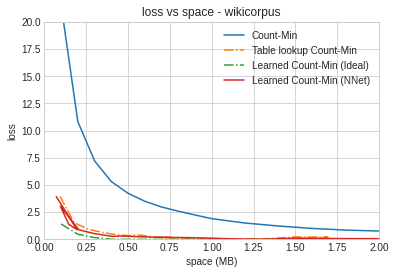

In [17]:

ALGO = 'Count-Min'
COUNT_MIN = 'param_results/count_min/cmin_wikicorpus.npz'
LEARNED = ['param_results/cutoff_count_min_param/cmin_wiki_test.npz']
PERFECT='param_results/cutoff_count_min_param_perfect/cmin_wiki_test.npz'
LOOKUP_TABLE ='param_results/lookup_table_count_min/cmin_wiki_test.npz' 
MODEL_NAMES= ["Learned Count-Min (NNet)"]
TITLE = 'wikicorpus'
MODEL_SIZES= [0.0052]
LOOKUP_SIZE= [0.0035]
X_LIM= [0,2]
Y_LIM= [0,20]

plvs = PlotLossVsSpace(
        count_min=COUNT_MIN,
        learned_cmin=LEARNED,
        model_names=MODEL_NAMES,
        perfect_ccm=PERFECT,
        lookup_table_ccm=LOOKUP_TABLE,
        model_sizes=MODEL_SIZES,
        lookup_size=LOOKUP_SIZE,
        x_lim=X_LIM,
        y_lim=Y_LIM,
        title=TITLE,
        algo=ALGO,
    )

plvs.run()